<a href="https://colab.research.google.com/github/JingyiSu/prelim/blob/main/Pass_040922.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup

In [ ]:
!pip install -qq jovian
!pip install -qq datasets
!pip install -qq transformers

     |████████████████████████████████| 68 kB 2.3 MB/s 
     |████████████████████████████████| 325 kB 11.6 MB/s 
     |████████████████████████████████| 1.1 MB 14.0 MB/s 
     |████████████████████████████████| 212 kB 33.3 MB/s 
     |████████████████████████████████| 77 kB 3.1 MB/s 
     |████████████████████████████████| 136 kB 39.1 MB/s 
     |████████████████████████████████| 127 kB 7.3 MB/s 
     |████████████████████████████████| 271 kB 35.8 MB/s 
     |████████████████████████████████| 94 kB 2.3 MB/s 
     |████████████████████████████████| 144 kB 35.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 4.0 MB 12.2 MB/s 
     |████████████████████████████████| 6.5 MB 33.8 MB/s 
     |████████████████████████████████| 596 

In [ ]:
!nvidia-smi

Sun Apr 10 00:05:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import transformers
import torch.nn.functional as F
import torch.nn.utils.rnn
from tqdm.notebook import tqdm

from transformers import AutoModel, AutoTokenizer, BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from transformers import DefaultDataCollator
from datasets import load_dataset, concatenate_datasets, ClassLabel, Value

import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 2. Load Data

In [ ]:
!pip install gdown
!mkdir data data/code2nl
!cd data/code2nl
!gdown https://drive.google.com/file/d/1rd2Tc6oUWBo7JouwexW3ksQ0PaOhUr6h
!unzip Cleaned_CodeSearchNet.zip
!rm Cleaned_CodeSearchNet.zip
!cd ../..

/usr/local/lib/python3.7/dist-packages/gdown/parse_url.py:39: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=None
  url="https://drive.google.com/uc?id={}".format(file_id)
Downloading...
From: https://drive.google.com/file/d/1rd2Tc6oUWBo7JouwexW3ksQ0PaOhUr6h
To: /content/1rd2Tc6oUWBo7JouwexW3ksQ0PaOhUr6h
69.4kB [00:00, 1.23MB/s]
unzip:  cannot find or open Cleaned_CodeSearchNet.zip, Cleaned_CodeSearchNet.zip.zip or Cleaned_CodeSearchNet.zip.ZIP.
rm: cannot remove 'Cleaned_CodeSearchNet.zip': No such file or directory


In [ ]:
DATASET_NAME = "code_x_glue_cc_defect_detection"

In [ ]:
dataset = load_dataset("code_x_glue_cc_defect_detection")

Reusing dataset code_x_glue_cc_defect_detection (/root/.cache/huggingface/datasets/code_x_glue_cc_defect_detection/default/0.0.0/b0f3f36d6908feee44326eb5d257cfe4a02fe9fa50dfe441cad249b0e0ebfb11)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset = concatenate_datasets([dataset['train'], dataset['validation'], dataset['test']])
#dataset_train = load_dataset("code_x_glue_cc_defect_detection", split='train')
dataset

Dataset({
    features: ['id', 'func', 'target', 'project', 'commit_id'],
    num_rows: 27318
})

In [ ]:
print(dataset.info)
print(dataset.split)
print(dataset.features)
print(dataset[0])

DatasetInfo(description='CodeXGLUE Defect-detection dataset, available at https://github.com/microsoft/CodeXGLUE/tree/main/Code-Code/Defect-detection\n\nGiven a source code, the task is to identify whether it is an insecure code that may attack software systems, such as resource leaks, use-after-free vulnerabilities and DoS attack. We treat the task as binary classification (0/1), where 1 stands for insecure code and 0 for secure code.\nThe dataset we use comes from the paper Devign: Effective Vulnerability Identification by Learning Comprehensive Program Semantics via Graph Neural Networks. We combine all projects and split 80%/10%/10% for training/dev/test.', citation='@inproceedings{zhou2019devign,\ntitle={Devign: Effective vulnerability identification by learning comprehensive program semantics via graph neural networks},\nauthor={Zhou, Yaqin and Liu, Shangqing and Siow, Jingkai and Du, Xiaoning and Liu, Yang},\nbooktitle={Advances in Neural Information Processing Systems},\npages=

In [ ]:
print(dataset.shape)
print(dataset.num_columns)
print(dataset.num_rows)
len(dataset)

(27318, 5)
5
27318


27318

## Rename column

In [ ]:
dataset = dataset.rename_column("target", "label")

In [ ]:
dataset.features

{'commit_id': Value(dtype='string', id=None),
 'func': Value(dtype='string', id=None),
 'id': Value(dtype='int32', id=None),
 'label': Value(dtype='bool', id=None),
 'project': Value(dtype='string', id=None)}

## Convert Value to ClassLabel Object

In [ ]:
# Creating a ClassLabel Object
df = dataset.to_pandas()
labels = df['label'].unique().tolist()
ClassLabels = ClassLabel(num_classes=len(labels), names=labels)

# Mapping Labels to IDs
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

# Casting label column to ClassLabel Object
dataset = dataset.cast_column('label', ClassLabels)

Loading cached processed dataset at /root/.cache/huggingface/datasets/code_x_glue_cc_defect_detection/default/0.0.0/b0f3f36d6908feee44326eb5d257cfe4a02fe9fa50dfe441cad249b0e0ebfb11/cache-6a01630a6226377b.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/code_x_glue_cc_defect_detection/default/0.0.0/b0f3f36d6908feee44326eb5d257cfe4a02fe9fa50dfe441cad249b0e0ebfb11/cache-749832ce2cbfe078.arrow


In [ ]:
dataset.features

{'commit_id': Value(dtype='string', id=None),
 'func': Value(dtype='string', id=None),
 'id': Value(dtype='int32', id=None),
 'label': ClassLabel(num_classes=2, names=[False, True], id=None),
 'project': Value(dtype='string', id=None)}

In [ ]:
df = dataset.to_pandas(dataset)

In [ ]:
print(df.shape)
print(df.isnull().values.any())
df.sample(5)

(27318, 5)
False


,id,func,label,project,commit_id
1097,1343,"static void esp_mem_writeb(void *opaque, targe...",1,qemu,8dea1dd406189dae6108104faf27f397835ae871
13950,17403,"void avfilter_start_frame(AVFilterLink *link, ...",1,FFmpeg,fe479c9d63f0743fa064ac2a5c019284ba88277a
25430,8793,static int vmdk_parse_extents(const char *desc...,1,qemu,ff74f33c310892c90c4439d963a6ce67f47ce18c
8130,10117,static inline void unpack_coeffs(SnowContext *...,0,FFmpeg,b44985ba12d927d643a7bc03b0db98b83bf4fc9e
12468,15528,static void sigp_store_adtl_status(void *arg)\...,0,qemu,7c72ac49ae9f38fa0125296e05988655157decb5


In [ ]:
df['func_length'] = df['func'].apply(lambda x: len(x))
#df = df.sort_values(by='id', ascending=True)
df.sample(5)

,id,func,label,project,commit_id,func_length
6929,8623,static uint16_t dummy_section(MemoryRegion *mr...,0,qemu,53cb28cbfea038f8ad50132dc8a684e638c7d48b,271
9758,12165,static void v9fs_clunk(void *opaque)\n\n{\n\n ...,1,qemu,c572f23a3e7180dbeab5e86583e43ea2afed6271,529
26744,21740,"qcrypto_block_luks_create(QCryptoBlock *block,...",0,qemu,375092332eeaa6e47561ce47fd36144cdaf964d0,17062
1115,1367,void put_signed_pixels_clamped_mmx(const DCTEL...,0,FFmpeg,7daabccb5d36e9bf649d157ab14ccb2a016f1c53,471
21502,26883,static void scsi_cancel_io(SCSIRequest *req)\n...,0,qemu,3df9caf88f5c0859ae380101fea47609ba1dbfbd,503


In [ ]:
#mean sentence length
np.mean(df['func_length'])

2023.9647119115602

In [ ]:
#changing ratings to 0-numbering
#zero_numbering = {1:0, 2:1, 3:2, 4:3, 5:4}
#reviews['rating'] = reviews['rating'].apply(lambda x: zero_numbering[x])

# 3. Data Pre-processing

ref: https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S#scrollTo=Vea9edaaxSPO

## PRE_TRAINED_MODEL_NAME

In [ ]:
PRE_TRAINED_MODEL_NAME = 'huggingface/CodeBERTa-small-v1'

# CodeBERT (Python, Java, JavaScript, PHP, Ruby, Go)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)#, num_labels = len(label_dict)) # for transformer 4.x

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing BertModel: ['roberta.encoder.layer.3.attention.self.key.bias', 'roberta.encoder.layer.5.attention.output.dense.bias', 'roberta.embeddings.token_type_embeddings.weight', 'roberta.encoder.layer.0.attention.self.key.bias', 'lm_head.dense.bias', 'roberta.encoder.layer.1.attention.self.query.weight', 'roberta.encoder.layer.1.attention.self.value.bias', 'roberta.encoder.layer.5.output.dense.bias', 'roberta.encoder.layer.2.intermediate.dense.weight', 'roberta.encoder.layer.2.attention.output.dense.weight', 'roberta.encoder.layer.2.output.LayerNorm.weight', 'roberta.encoder.layer.4.attention.output.dense.weight', 'roberta.encoder.layer.0.output.LayerNorm.bias', 'roberta.encoder.layer.1.attention.self.key.bias', 'roberta.encoder.layer.1.attenti

### Filter #token >500

In [ ]:
token_lens = []

for txt in df.func:
  tokens = tokenizer.encode(txt)# ), max_length=512, truncation=True)
  token_lens.append(len(tokens))

Token indices sequence length is longer than the specified maximum sequence length for this model (882 > 512). Running this sequence through the model will result in indexing errors


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


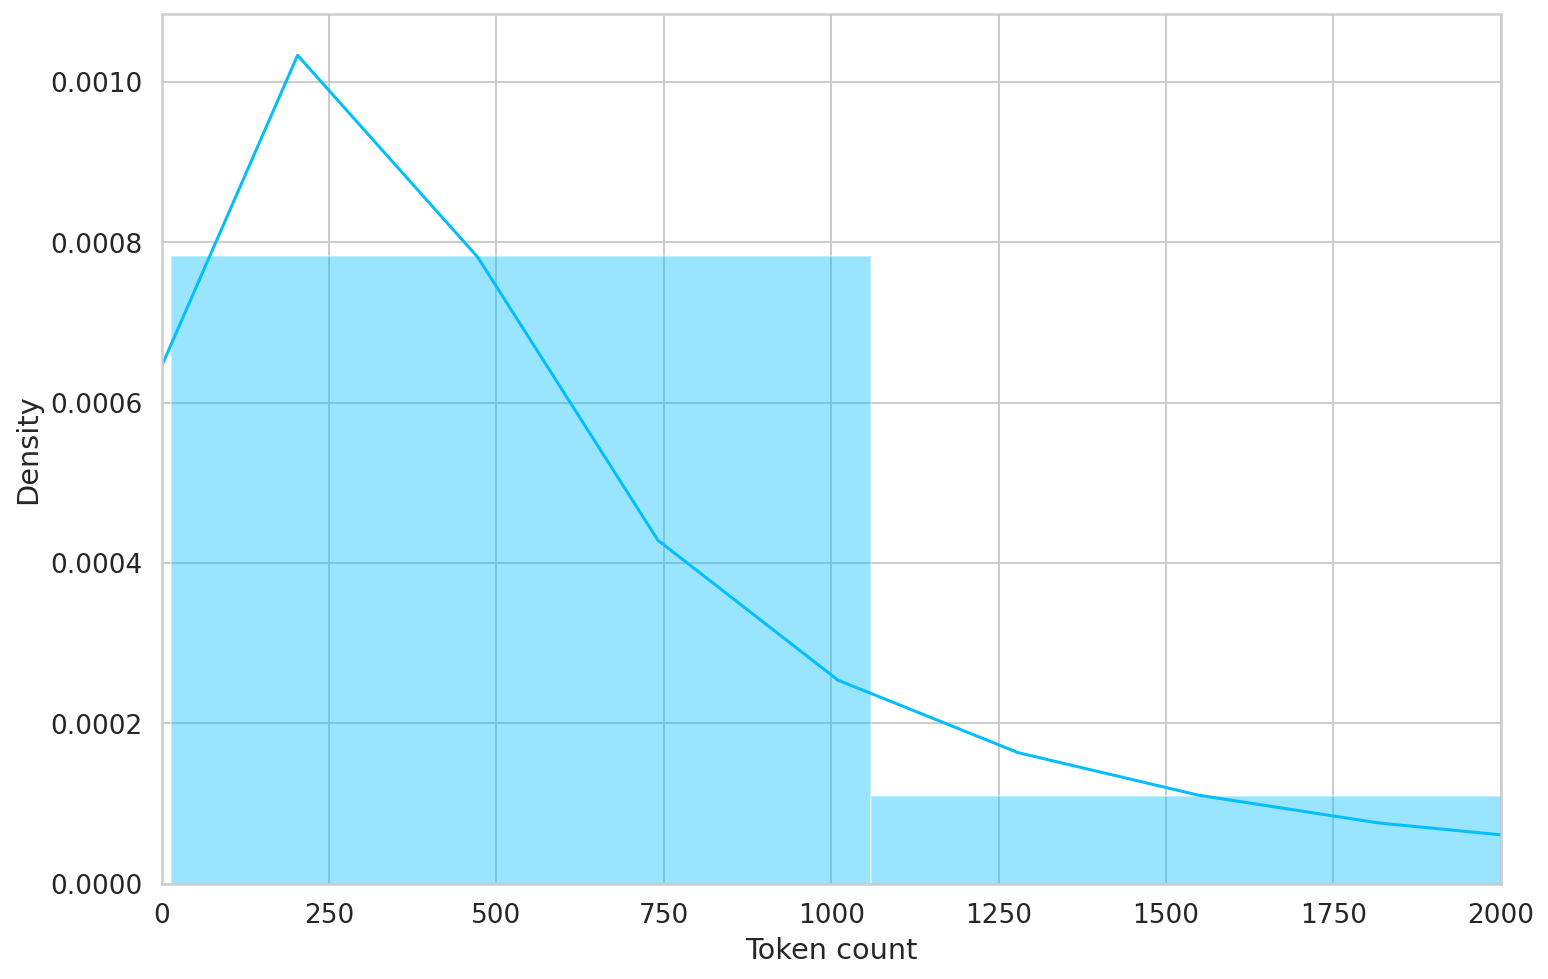

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 2000]);
plt.xlabel('Token count');

In [ ]:
df['len_tokens'] = token_lens

In [ ]:
df = df[df['len_tokens'] <= 256]

## MAX_LEN

In [ ]:
MAX_LEN = 256

## Dataset class

In [ ]:
class CustomDataset(Dataset):

  def __init__(self, funcs, labels, tokenizer, max_len):
    self.funcs = funcs
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.funcs)
  
  def __getitem__(self, item):
    func = str(self.funcs[item])
    label = self.labels[item]

    encoding = self.tokenizer.encode_plus(
      func,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      truncation=True,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'func_text': func,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'labels': torch.tensor(label, dtype=torch.long)
    }

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((9548, 7), (530, 7), (531, 7))

In [ ]:
data_collator = DefaultDataCollator(return_tensors="pt")

In [ ]:
possible_labels = df_train.label.unique()

In [ ]:
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
    
label_dict

{0: 1, 1: 0}

## Dataloader

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = CustomDataset(
    funcs=df.func.to_numpy(),
    labels=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    #collate_fn=data_collator, for some reason it removed 'func_text'
    shuffle=True, # shuffles the data and then batches.
    num_workers=2 # optimization
  )

## BATCH_SIZE

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
df_train

,id,func,label,project,commit_id,func_length,len_tokens
24028,21704,static int qemu_reset_requested(void)\n\n{\n\n...,1,qemu,aedbe19297907143f17b733a7ff0e0534377bed1,212,74
27,33,"void helper_slbie(CPUPPCState *env, target_ulo...",1,qemu,cd0c6f473532bfaf20a095bc90a18e45162981b5,525,222
21107,26380,"static uint32_t pci_up_read(void *opaque, uint...",1,qemu,7faa8075d898ae56d2c533c530569bb25ab86eaf,197,95
11790,14674,target_ulong helper_dmt(target_ulong arg1)\n\n...,1,qemu,9ed5726c043958359b0f1fa44ab3e4f25f9d9a47,115,53
24530,26676,"void qmp_object_add(const char *type, const ch...",0,qemu,240f64b6dc3346d044d7beb7cc3a53668ce47384,665,246
...,...,...,...,...,...,...,...
14685,18348,static void do_multiwrite(BlockDriverState *bs...,0,qemu,c20fd872257fb9abd2ce99741937c0f65aa162b7,371,145
13282,16551,"void stq_phys(target_phys_addr_t addr, uint64_...",0,qemu,a8170e5e97ad17ca169c64ba87ae2f53850dab4c,131,59
13753,17149,static void raw_invalidate_cache(BlockDriverSt...,0,qemu,22d5cd82e98b61b1dbd791fab9f4ae0f77c0ed14,413,161
2150,2621,"void qmp_drive_backup(DriveBackup *arg, Error ...",1,qemu,111049a4ecefc9cf1ac75c773f4c5c165f27fe63,106,44


In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['func_text', 'input_ids', 'attention_mask', 'labels'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])


### Sample test

In [ ]:
sample_txt = df["func"].iloc[-1]
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

#print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

   Tokens: ['static', 'Ġinline', 'Ġvoid', 'Ġgen', '_', 'op', '_', 'eval', '_', 'fbo', '(', 'TC', 'G', 'v', 'Ġdst', ',', 'ĠT', 'CG', 'v', 'Ġsrc', ',', 'Ċ', 'Ċ', 'ĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠ', 'Ġunsigned', 'Ġint', 'Ġf', 'cc', '_', 'offset', ')', 'Ċ', 'Ċ', '{', 'Ċ', 'Ċ', 'ĠĠĠ', 'Ġgen', '_', 'mov', '_', 'reg', '_', 'FC', 'C', '0', '(', 'dst', ',', 'Ġsrc', ',', 'Ġf', 'cc', '_', 'offset', ');', 'Ċ', 'Ċ', 'ĠĠĠ', 'Ġgen', '_', 'mov', '_', 'reg', '_', 'FC', 'C', '1', '(', 'cpu', '_', 'tmp', '0', ',', 'Ġsrc', ',', 'Ġf', 'cc', '_', 'offset', ');', 'Ċ', 'Ċ', 'ĠĠĠ', 'Ġtc', 'g', '_', 'gen', '_', 'and', '_', 'tl', '(', 'dst', ',', 'Ġdst', ',', 'Ġcpu', '_', 'tmp', '0', ');', 'Ċ', 'Ċ', 'ĠĠĠ', 'Ġtc', 'g', '_', 'gen', '_', 'xor', 'i', '_', 'tl', '(', 'dst', ',', 'Ġdst', ',', 'Ġ0', 'x', '1', ');', 'Ċ', 'Ċ', '}', 'Ċ']
Token IDs: [2474, 9115, 954, 3711, 67, 649, 67, 5879, 67, 29854, 12, 14436, 43, 90, 4702, 16, 461, 18011, 90, 2626, 16, 203, 203, 1980, 14941, 664, 293, 3115, 67, 1758, 13, 203, 203, 9

In [ ]:
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

</s> 2
<s> 0
<pad> 1
<unk> 3


In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=MAX_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  truncation=True,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

256


tensor([    0,  2474,  9115,   954,  3711,    67,   649,    67,  5879,    67,
        29854,    12, 14436,    43,    90,  4702,    16,   461, 18011,    90,
         2626,    16,   203,   203,  1980, 14941,   664,   293,  3115,    67,
         1758,    13,   203,   203,    95,   203,   203,   263,  3711,    67,
        37877,    67,  1114,    67,  6355,    39,    20,    12,  4430,    16,
         2626,    16,   293,  3115,    67,  1758,   285,   203,   203,   263,
         3711,    67, 37877,    67,  1114,    67,  6355,    39,    21,    12,
         7484,    67,  2349,    20,    16,  2626,    16,   293,  3115,    67,
         1758,   285,   203,   203,   263,  2751,    75,    67,  3006,    67,
          383,    67,  4850,    12,  4430,    16,  4702,    16, 10437,    67,
         2349,    20,   285,   203,   203,   263,  2751,    75,    67,  3006,
           67, 21450,    77,    67,  4850,    12,  4430,    16,  4702,    16,
          430,    92,    21,   285,   203,   203,    97,   203, 

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

256


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

['<s>', 'static', 'Ġinline', 'Ġvoid', 'Ġgen', '_', 'op', '_', 'eval', '_', 'fbo', '(', 'TC', 'G', 'v', 'Ġdst', ',', 'ĠT', 'CG', 'v', 'Ġsrc', ',', 'Ċ', 'Ċ', 'ĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠ', 'Ġunsigned', 'Ġint', 'Ġf', 'cc', '_', 'offset', ')', 'Ċ', 'Ċ', '{', 'Ċ', 'Ċ', 'ĠĠĠ', 'Ġgen', '_', 'mov', '_', 'reg', '_', 'FC', 'C', '0', '(', 'dst', ',', 'Ġsrc', ',', 'Ġf', 'cc', '_', 'offset', ');', 'Ċ', 'Ċ', 'ĠĠĠ', 'Ġgen', '_', 'mov', '_', 'reg', '_', 'FC', 'C', '1', '(', 'cpu', '_', 'tmp', '0', ',', 'Ġsrc', ',', 'Ġf', 'cc', '_', 'offset', ');', 'Ċ', 'Ċ', 'ĠĠĠ', 'Ġtc', 'g', '_', 'gen', '_', 'and', '_', 'tl', '(', 'dst', ',', 'Ġdst', ',', 'Ġcpu', '_', 'tmp', '0', ');', 'Ċ', 'Ċ', 'ĠĠĠ', 'Ġtc', 'g', '_', 'gen', '_', 'xor', 'i', '_', 'tl', '(', 'dst', ',', 'Ġdst', ',', 'Ġ0', 'x', '1', ');', 'Ċ', 'Ċ', '}', 'Ċ', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', 

In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [ ]:
print(last_hidden_state.shape)
print(bert_model.config.hidden_size)
print(pooled_output.shape)

torch.Size([1, 256, 768])
768
torch.Size([1, 768])


# Model

In [ ]:
#BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME).config

In [ ]:
class CustomModel(nn.Module):

  def __init__(self, n_classes):
    super(CustomModel, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    #self.drop = nn.Dropout(p=0.3)

    self.lstm = nn.LSTM(self.bert.config.hidden_size, self.bert.config.hidden_size, bidirectional=False)

    self.linear = nn.Linear(self.bert.config.hidden_size, n_classes) # fully connected layer
  
  def forward(self, input_ids, attention_mask):
    # output from bert
    sequence_output, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False # for transformer 4.x
    ) 

    

    # Dropout
    #output = self.drop(pooled_output)

    # LSTM
    lstm_output, (h,c) = self.lstm(sequence_output) ## extract the 1st token's embeddings
    hidden = torch.cat((lstm_output[:,-1, :self.bert.config.hidden_size],lstm_output[:,0, self.bert.config.hidden_size:]),dim=-1)
    
    # Linear
    #output = self.out(output)
    linear_output = self.linear(hidden.view(-1,self.bert.config.hidden_size)) ### assuming that you are only using the output of the last LSTM cell to perform classification

    output = linear_output
    
    return output

In [ ]:
class_names = ['False', 'True']

In [ ]:
model = CustomModel(len(class_names))
model = model.to(device)

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing BertModel: ['roberta.encoder.layer.3.attention.self.key.bias', 'roberta.encoder.layer.5.attention.output.dense.bias', 'roberta.embeddings.token_type_embeddings.weight', 'roberta.encoder.layer.0.attention.self.key.bias', 'lm_head.dense.bias', 'roberta.encoder.layer.1.attention.self.query.weight', 'roberta.encoder.layer.1.attention.self.value.bias', 'roberta.encoder.layer.5.output.dense.bias', 'roberta.encoder.layer.2.intermediate.dense.weight', 'roberta.encoder.layer.2.attention.output.dense.weight', 'roberta.encoder.layer.2.output.LayerNorm.weight', 'roberta.encoder.layer.4.attention.output.dense.weight', 'roberta.encoder.layer.0.output.LayerNorm.bias', 'roberta.encoder.layer.1.attention.self.key.bias', 'roberta.encoder.layer.1.attenti

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 256])
torch.Size([16, 256])


We'll move the example batch of our training data to the GPU:

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4860, 0.5140],
        [0.4729, 0.5271],
        [0.4680, 0.5320],
        [0.4626, 0.5374],
        [0.4590, 0.5410],
        [0.4594, 0.5406],
        [0.4590, 0.5410],
        [0.4575, 0.5425],
        [0.4557, 0.5443],
        [0.4570, 0.5430],
        [0.4575, 0.5425],
        [0.4566, 0.5434],
        [0.4552, 0.5448],
        [0.4566, 0.5434],
        [0.4568, 0.5432],
        [0.4575, 0.5425]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Helpers

In [ ]:
EPOCHS = 5

optimizer = optim.AdamW(model.parameters(), lr=2e-5)#, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted')

In [ ]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
def train_epoch(model,  data_loader,  loss_fn,  optimizer,  device,  scheduler,  n_examples,  
                epoch  
                #loss_train_total
):

  model = model.train()
  losses = []
  correct_predictions = 0

  progress_bar = tqdm(train_data_loader, 
                        desc=f'Epoch {epoch}', 
                        leave=False, 
                        disable=False)

  for batch in progress_bar:
    #batch = tuple(b for b in batch)
    #model.zero_grad()

    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)
    #loss_train_total +=loss.item()
    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()

    optimizer.zero_grad()

    #progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))}) 
  
  #loss_train_avg = loss_train_total/len(data_loader)
  #tqdm.write(f'Training loss: {loss_train_avg}')
  
  accuracy = correct_predictions.to("cpu").numpy() / n_examples

  return accuracy, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):

  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for batch in tqdm(data_loader):
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      labels = batch["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

      accuracy = correct_predictions.to("cpu").numpy() / n_examples

  return accuracy, np.mean(losses)

# Training

How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

Batch size: 16, 32

Learning rate (Adam): 5e-5, 3e-5, 2e-5

Number of epochs: 2, 3, 4

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in tqdm(range(1, EPOCHS+1)):

  #loss_train_total = 0
  print('-' * 12)
  print(f'Progress {epoch - 1}/{EPOCHS}')
  
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train),
    epoch
    #loss_train_total
  )
  print(f'Train loss: {train_loss}, Accuracy: {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss: {val_loss}, Accuracy: {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), f'best_model.bin')
    best_accuracy = val_acc

  0%|          | 0/5 [00:00<?, ?it/s]

------------
Progress 0/5


Epoch 1:   0%|          | 0/597 [00:00<?, ?it/s]

RuntimeError: ignored

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0, 1]);
plt.xlim([0, EPOCHS - 1]);
plt.legend()

## Can push pre-trained model and use later

In [ ]:
# !gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA
# model = CustomModel(len(class_names))
# model.load_state_dict(torch.load('best_model_state.bin'))
# model = model.to(device)

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

# Evaluation

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  func_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["func_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["labels"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      func_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return func_texts, predictions, prediction_probs, real_values

In [ ]:
y_func_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

### Push to Hub

In [ ]:
#from huggingface_hub import notebook_login

#notebook_login()

In [ ]:
#model.push_to_hub("my-awesome-model")

# Manual test

In [ ]:
idx = 2
func_text = y_func_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})
print("\n".join(wrap(func_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('Defect')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [ ]:
func_text = '''
int max(int num1, int num2) {

   /* local variable declaration */
   int result;
 
   if (num1 > num2)
      result = num1;
   else
      result = num2;
 
   return result; 
}'''

In [ ]:
encoded_func = tokenizer.encode_plus(
  func_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  #pad_to_max_length=True,
  truncation=True,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_func['input_ids'].to(device)
attention_mask = encoded_func['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Func: {func_text}')
print(f'Label  : {class_names[prediction]}')